In [1]:
##LIBRERIAS##
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from scipy.constants import k as k_B 
from matplotlib.patches import Circle
from matplotlib import animation
from matplotlib.lines import Line2D
from IPython.display import HTML
import matplotlib.pyplot as plt


In [2]:
##CONSTANTES##

T = 310.0  # Temperatura corporal ~37°C [K]
AVOGADRO = 6.022e23  # Número de Avogadro
#Relaciones de cantidades
C = 15; r = 304; G = 35; E = 5; nanodomin_space = 10 # tamaño del radio del disco


In [ ]:
##CREACIÓN DE MOLÉCULAS##

class Molecule:
    def __init__(self, name, pos, vel, color, ratio_molecular, energy, mass, 
                 active=False, mobile=True, temperature=300.0):
        self.name = name         
        self.pos = np.array(pos, dtype=float)   
        self.vel = np.array(vel, dtype=float)   
        self.color = color       
        self.ratio = float(ratio_molecular)  
        self.energy = float(energy)         
        self.active = active     
        self.m = float(mass)
        self.mobile = mobile
        self.collision_count = 0
        self.temperature = temperature 

    def set_temperature(self, temp):
        """Establece la temperatura y ajusta la velocidad correspondientemente"""
        self.temperature = temp
        self.update_speed_from_temperature()
    
    def update_speed_from_temperature(self):
        """Actualiza la velocidad basándose en la temperatura usando teoría cinética"""
        if self.temperature <= 0 or not self.mobile:
            self.vel = np.array([0.0, 0.0])
            self.energy = 0.0
            return
            
        # Velocidad promedio según teoría cinética
        mean_speed = np.sqrt(8 * k_B * self.temperature / (np.pi * self.m))
        
        # Para simulación 2D, generamos dirección aleatoria
        angle = np.random.uniform(0, 2 * np.pi)
        self.vel = np.array([mean_speed * np.cos(angle), mean_speed * np.sin(angle)])
        
        # Actualizar energía
        self.update_energy_from_speed()

    def update_speed_from_energy(self):
        """Recalcula velocidad desde energía (mantiene dirección)"""
        if self.energy <= 0:
            self.vel = np.array([0.0, 0.0]) 
            return
            
        speed = np.sqrt(2.0 * self.energy / self.m)
        
        current_speed = np.linalg.norm(self.vel)
        
        if current_speed > 1e-9:
            direction = self.vel / current_speed  
            self.vel = direction * speed         
        else:
            angle = np.random.uniform(0, 2 * np.pi)
            self.vel = np.array([speed * np.cos(angle), speed * np.sin(angle)])

    def update_energy_from_speed(self):
        """Recalcula energía desde velocidad actual"""
        speed = np.linalg.norm(self.vel)
        self.energy = 0.5 * self.m * (speed ** 2)


    def move(self, L, dt=0.1):
        if not self.mobile:
            return  
        
        # Coeficientes de difusión más realistas
        if self.name == "Rh*":
            D = 0.5  # Molécula más grande
        elif self.name == "GMPc":
            D =1.5  # Molécula pequeña, se mueve más
        elif self.name == "G*" or self.name == "G_inact":
            D = 0.8
        elif self.name == "PDE*" or self.name == "PDE_inact":
            D = 0.6
        else:
            D = 0.05
        
        # Desplazamiento browniano: Δx = √(2DΔt) * dirección_aleatoria
        angle = np.random.uniform(0, 2 * np.pi)
        brownian_displacement = np.sqrt(2 * D * dt) * np.array([np.cos(angle), np.sin(angle)])
        new_pos = self.pos + brownian_displacement
        self.pos = new_pos
        
    def check_collision(self, other, L):
        """Verifica colisión física entre dos moléculas"""
        distance = np.linalg.norm(self.pos - other.pos)
        collision_occurred = distance < (self.ratio + other.ratio)
        if collision_occurred:
            return True
        return False

    def handle_reaction_collision(self, other, system):
        """Maneja colisión con reacción química CON probabilidades"""
        
        # Probabilidades basadas en física fundamental
        reaction_probabilities = {
            "rh_g": 1,    # Rh* + G_inact -> G* (baja por complejidad estérica)
            "g_pde": 0.5,   # G* + PDE_inact -> PDE* (aún más compleja)
            "pde_gmpc": 0.75 # PDE* + GMPc -> hidrólisis (más alta, molécula pequeña)
        }
        
        reaction_type = None
        success = False
        
        # Rh* + G_inact -> G*
        if (self.name == "Rh*" and other.name == "G_inact") or (other.name == "Rh*" and self.name == "G_inact"):
            reaction_type = "rh_g"
            success = np.random.random() < reaction_probabilities["rh_g"]
            
        # G* + PDE_inact -> PDE*
        elif (self.name == "G*" and other.name == "PDE_inact") or (other.name == "G*" and self.name == "PDE_inact"):
            reaction_type = "g_pde" 
            success = np.random.random() < reaction_probabilities["g_pde"]
            
        # PDE* + GMPc -> hidrólisis
        elif (self.name == "PDE*" and other.name == "GMPc") or (other.name == "PDE*" and self.name == "GMPc"):
            reaction_type = "pde_gmpc"
            success = np.random.random() < reaction_probabilities["pde_gmpc"]
    
            if success and reaction_type:
                if reaction_type == "rh_g":
                    if self.name == "G_inact":
                        self.convert_to("G*", system)
                    else:
                        other.convert_to("G*", system)
                elif reaction_type == "g_pde":
                    if self.name == "PDE_inact":
                        self.convert_to("PDE*", system)  
                    else:
                        other.convert_to("PDE*", system)
                elif reaction_type == "pde_gmpc":
                        if self.name == "GMPc":
                            system.mark_for_removal.append(self)
                        else:
                            system.mark_for_removal.append(other)
                
                return reaction_type
            
            return None


    def handle_physical_collision(self, other, system): #Se está haciendo a pares# 
        """Maneja colisión física elástica"""
        if not self.mobile and not other.mobile:
            return
            
        delta_pos = other.pos - self.pos
        distance = np.linalg.norm(delta_pos)
        
        if distance < 1e-12:
            return
            
        normal = delta_pos / distance
        
        if self.mobile and not other.mobile:
            v_dot_n = np.dot(self.vel, normal)
            self.vel = self.vel - 2.0 * v_dot_n * normal
            
        elif other.mobile and not self.mobile:
            v_dot_n = np.dot(other.vel, normal)
            other.vel = other.vel - 2.0 * v_dot_n * normal
    


    def convert_to(self, new_type, system):
        """Convierte esta molécula a otro tipo"""
        # Modifica las propiedades en convert_to y creación inicial:
        type_properties = {
            "G*": {"color": "#3498DB", "ratio": 0.15, "active": True, "mobile": True},        # AZUL
            "G_inact": {"color": "#2ECC71", "ratio": 0.15, "active": False, "mobile": True},  # VERDE
            "PDE*": {"color": "#F1C40F", "ratio": 0.25, "active": True, "mobile": True},      # AMARILLO
            "PDE_inact": {"color": "#F39C12", "ratio": 0.25, "active": False, "mobile": True}, # NARANJA
            "Rh*": {"color": "#7D3C98", "ratio": 0.12, "active": True, "mobile": True},       # MORADO
            "GMPc": {"color": "#E74C3C", "ratio": 0.08, "active": False, "mobile": True}      # ROJO
        }
        

        if new_type in type_properties:
            props = type_properties[new_type]
            self.name = new_type
            self.color = props["color"]
            self.ratio = props["ratio"]
            self.active = props["active"]
            self.mobile = props["mobile"]
        

def create_thermal_molecule(name, pos, color, ratio, mass, temperature=310.0, 
                           active=False, mobile=True):
    """Crea una molécula con velocidad inicial basada en temperatura"""
    molecule = Molecule(name, pos, [0, 0], color, ratio, 0, mass, 
                       active, mobile, temperature)
    molecule.update_speed_from_temperature()
    return molecule

In [ ]:
## PROCESO DE LA FOTOTRANSDUCCIÓN ##
class PhototransductionSystem:
    def __init__(self, L, verbose=False):
        self.molecules = []
        self.L = L
        self.center = np.array([L/2, L/2])
        self.R = nanodomin_space  # ¡USA EL RADIO DEFINIDO!
        self.current_time = 0.0
        self.verbose = verbose
        self.metrics_history = []
        
        # Historiales específicos para cada tipo de colisión
        self.rh_g_collisions = []
        self.g_pde_collisions = []
        self.pde_gmpc_collisions = []
        self.current_history = []
        self.mark_for_removal = []
        
        # Variables para la corriente biofísica
        self.current_cGMP = 4.0          # µM (nivel oscuro típico)
        self.current_Ca = 0.5            # µM (nivel basal de Ca2+)
        self.active_PDE_fraction = 0.0   # fracción de PDE activas (0-1)
        
        # Parámetros para dinámica realista
        self.hill_coefficient = 2.5
        self.current_amplitude = 1.0
        self.deactivation_rate = 0.02
        self.initial_cGMP = C  # Guardar valor inicial para referencia

    # ============================================================
    # POSICIONES ESPACIALES
    # ============================================================
    def random_position_in_disk(self):
        u = np.random.random()
        r = 0.9 * self.R * np.sqrt(u)  # Más cerca del centro
        theta = 2 * np.pi * np.random.random()
        x = self.center[0] + r * np.cos(theta)
        y = self.center[1] + r * np.sin(theta)
        return [x, y]

    def random_position_outside_disk(self):
        """Posición fuera del disco de fototransducción"""
        for _ in range(100):
            x = np.random.uniform(0, self.L)
            y = np.random.uniform(0, self.L)
            dx = x - self.center[0]
            dy = y - self.center[1]
            dist = np.sqrt(dx**2 + dy**2)
            if dist > self.R: 
                return [x, y]
        return [self.L * 0.8, self.L * 0.8] 

    # ============================================================
    # CORRIENTE Y BIOFÍSICA
    # ============================================================
    def update_current(self, dt=0.05):
        """
        Corriente total = CNG (rápida, dependiente de cGMP)
                        - NCKX (retardada, dependiente de Ca2+)
        """

        # --- parámetros del modelo ---
        n = 3.5           # cooperatividad del canal CNG
        K_cG = 2.5        # µM, semisaturación CNG
        K_ex = 0.3        # µM, semisaturación intercambiador
        I_CNG_max = 1.0   # corriente máxima de entrada
        I_ex_max = 0.3    # corriente máxima del intercambiador
        tau_ex = 2.0      # ms, retardo del intercambiador (semi-step)

        # --- estados actuales ---
        cG = self.current_cGMP
        Ca = self.current_Ca

        # --- fracción de PDE activas ---
        total_PDE = max(1, E)
        active_PDE = sum(1 for mol in self.molecules if mol.name == "PDE*")
        self.active_PDE_fraction = active_PDE / total_PDE
        I_CNG = I_CNG_max * (cG**n) / (cG**n + K_cG**n)

        # Corriente del intercambiador (NCKX) con retardo
        if not hasattr(self, "prev_I_ex"):
            self.prev_I_ex = I_ex_max * (Ca / (K_ex + Ca))
        I_ex_target = I_ex_max * (Ca / (K_ex + Ca))
        alpha = dt / max(tau_ex, dt)
        I_ex = (1 - alpha) * self.prev_I_ex + alpha * I_ex_target
        self.prev_I_ex = I_ex

        # Corriente total (positiva hacia afuera = hiperpolarización)
        I_total = I_ex - I_CNG  

        # Dinámica interna de cGMP y Ca2+
        k_syn = 0.05       # síntesis por GC
        k_hyd = 0.1        # hidrólisis por PDE activa
        dcG = dt * (k_syn - k_hyd * self.active_PDE_fraction * cG)
        self.current_cGMP = max(cG + dcG, 1e-4)

        dCa = dt * (0.02 * I_CNG - 0.05 * I_ex)
        self.current_Ca = max(Ca + dCa, 1e-5)

        # Guardar resultado normalizado
        self.current_history.append(I_total / I_CNG_max)
        self.current_time += dt

    # ============================================================
    # MÉTRICAS Y COLISIONES
    # ============================================================
    def get_system_metrics(self):
        """Retorna métricas del sistema"""
        gmpc_count = sum(1 for mol in self.molecules if mol.name == "GMPc")
        current_val = self.current_history[-1] if self.current_history else 1.0
        return {
            'time': self.current_time,
            'GMPc_remaining': gmpc_count,
            'Rh_active': sum(1 for mol in self.molecules if mol.name == "Rh*"),
            'G_active': sum(1 for mol in self.molecules if mol.name == "G*"),
            'PDE_active': sum(1 for mol in self.molecules if mol.name == "PDE*"),
            'current': current_val,
            'total_molecules': len(self.molecules),
            'cGMP_concentration': self.current_cGMP,
            'Ca_concentration': self.current_Ca
        }

    def check_all_collisions(self, cell_size=0.2):
        grid = {}
        for i, mol in enumerate(self.molecules):
            cx, cy = int(mol.pos[0] // cell_size), int(mol.pos[1] // cell_size)
            grid.setdefault((cx, cy), []).append(i)

        rh_g_count = g_pde_count = pde_gmpc_count = 0
        checked = set()
        
        for (cx, cy), indices in grid.items():
            neighbors = [(cx + dx, cy + dy) for dx in (-1,0,1) for dy in (-1,0,1)]
            neighbor_indices = [idx for nb in neighbors for idx in grid.get(nb, [])]
            
            for i in indices:
                mol1 = self.molecules[i]
                for j in neighbor_indices:
                    if i >= j or (i, j) in checked: 
                        continue
                    mol2 = self.molecules[j]
                    if mol1.check_collision(mol2, self.L):
                        reaction_type = mol1.handle_reaction_collision(mol2, self)
                        if reaction_type == "rh_g": rh_g_count += 1
                        elif reaction_type == "g_pde": g_pde_count += 1
                        elif reaction_type == "pde_gmpc": pde_gmpc_count += 1
                        else: mol1.handle_physical_collision(mol2, self)
                    checked.add((i, j))
        
        return rh_g_count, g_pde_count, pde_gmpc_count

    def update(self, dt=0.1):
        """Actualiza el sistema"""
        for molecule in self.molecules:
            molecule.move(self.L, dt)

        rh_g, g_pde, pde_gmpc = self.check_all_collisions()
        if self.mark_for_removal:
            for molecule in self.mark_for_removal:
                if molecule in self.molecules:
                    self.molecules.remove(molecule)
            self.mark_for_removal.clear()

        self.update_current(dt)
        self.current_time += dt

        metrics = self.get_system_metrics()
        self.metrics_history.append(metrics)

        self.rh_g_collisions.append(rh_g)
        self.g_pde_collisions.append(g_pde)
        self.pde_gmpc_collisions.append(pde_gmpc)

        return rh_g, g_pde, pde_gmpc, metrics['current']

    # ============================================================
    # MODOS DE INICIALIZACIÓN
    # ============================================================
    def initialize_single_photon(self):
        """Modo de un solo fotón: una Rh* activa en el centro"""
        self.molecules.clear()

        # Rh* única
        self.molecules.append(Molecule(
            name="Rh*", pos=[self.L/2, self.L/2],
            vel=[random.uniform(-1, 1), random.uniform(-1, 1)],
            color="purple", ratio_molecular=0.3,
            energy=10, mass=2, active=True, mobile=True
        ))

        # Rh inactivas
        for _ in range(r):
            self.molecules.append(Molecule(
                name="Rh_inact", pos=self.random_position_in_disk(),
                vel=[0,0], color="violet", ratio_molecular=0.3,
                energy=0, mass=2, active=False, mobile=True
            ))

        # G inactivas
        for _ in range(G):
            self.molecules.append(Molecule(
                name="G_inact", pos=self.random_position_in_disk(),
                vel=[random.uniform(-0.5, 0.5), random.uniform(-0.5, 0.5)],
                color="lightblue", ratio_molecular=0.2,
                energy=0, mass=1.5, mobile=True
            ))

        # PDE inactivas
        for _ in range(E):
            self.molecules.append(Molecule(
                name="PDE_inact", pos=self.random_position_in_disk(),
                vel=[0,0], color="pink", ratio_molecular=0.25,
                energy=0, mass=2, mobile=True
            ))

        # GMPc fuera del disco
        for _ in range(C):
            self.molecules.append(Molecule(
                name="GMPc", pos=self.random_position_outside_disk(),
                vel=[random.uniform(-1,1), random.uniform(-1,1)],
                color="white", ratio_molecular=0.1,
                energy=0, mass=1, mobile=True
            ))

        self.metrics_history = []
        self.rh_g_collisions = []
        self.g_pde_collisions = []
        self.pde_gmpc_collisions = []
        self.current_history = []
        self.current_time = 0.0
        self.mark_for_removal = []

        self.current_cGMP = 4.0
        self.current_Ca = 0.5
        self.active_PDE_fraction = 0.0
        self.update_current(0.1)

    def initialize_multi_photon(self, fraction_active=1.0):
        """Modo flash múltiple: varias Rh activas según fracción"""
        self.molecules.clear()

        rh_list = []
        for _ in range(r):
            mol = Molecule(
                name="Rh_inact", pos=self.random_position_in_disk(),
                vel=[0,0], color="violet", ratio_molecular=0.3,
                energy=0, mass=2, active=False, mobile=True
            )
            self.molecules.append(mol)
            rh_list.append(mol)

        # Activar fracción de Rh
        n_active = max(1, int(len(rh_list) * fraction_active))
        active_idx = np.random.choice(range(len(rh_list)), n_active, replace=False)
        for idx in active_idx:
            rh_list[idx].convert_to("Rh*", self)

        # G y PDE inactivas
        for _ in range(G):
            self.molecules.append(Molecule(
                name="G_inact", pos=self.random_position_in_disk(),
                vel=[random.uniform(-0.5,0.5), random.uniform(-0.5,0.5)],
                color="lightblue", ratio_molecular=0.2,
                energy=0, mass=1.5, mobile=True
            ))

        for _ in range(E):
            self.molecules.append(Molecule(
                name="PDE_inact", pos=self.random_position_in_disk(),
                vel=[0,0], color="pink", ratio_molecular=0.25,
                energy=0, mass=2, mobile=True
            ))

        for _ in range(C):
            self.molecules.append(Molecule(
                name="GMPc", pos=self.random_position_outside_disk(),
                vel=[random.uniform(-1,1), random.uniform(-1,1)],
                color="white", ratio_molecular=0.1,
                energy=0, mass=1, mobile=True
            ))

        self.metrics_history = []
        self.rh_g_collisions = []
        self.g_pde_collisions = []
        self.pde_gmpc_collisions = []
        self.current_history = []
        self.current_time = 0.0
        self.mark_for_removal = []

        self.current_cGMP = 4.0
        self.current_Ca = 0.5
        self.active_PDE_fraction = 0.0
        self.update_current(0.1)


In [ ]:
def run_complete_experiment(L, steps, dt, seed=42):
    """Ejecuta un experimento completo para un tamaño L dado"""
    random.seed(seed)
    np.random.seed(seed)
    
    system = PhototransductionSystem(L)
    system.initialize_single_photon()
    
    times = []
    rh_g_data = []
    g_pde_data = []
    pde_gmpc_data = []
    current_data = []
    
    for step in range(steps):
        rh_g, g_pde, pde_gmpc, current = system.update(dt)
        times.append(system.current_time)
        rh_g_data.append(rh_g)
        g_pde_data.append(g_pde)
        pde_gmpc_data.append(pde_gmpc)
        current_data.append(current)
    
    return (np.array(times), np.array(rh_g_data), np.array(g_pde_data), 
            np.array(pde_gmpc_data), np.array(current_data))

In [ ]:
def plot_complete_analysis(radios=[1.0*nanodomin_space, 0.5*nanodomin_space, 2.0*nanodomin_space], steps=60000, dt=0.05):
    """Grafica el número acumulado de colisiones a lo largo del tiempo"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    color_n1 = "#D6259B"
    color_n2 = "#51D63F"
    color_n3 = "#2580D6"    
    colors = [color_n1, color_n2, color_n3]
    labels = [f'R = {r}' for r in radios]
    
    # Recopilar todos los datos en un solo bucle
    all_data = {}
    for i, radio in enumerate(radios):
        L = radio * 2
        times, rh_g, g_pde, pde_gmpc, current = run_complete_experiment(L, steps, dt, seed=int(radio*100))
        all_data[radio] = (times, rh_g, g_pde, pde_gmpc, current)
    
    # Configuración de los subplots
    plot_configs = [
        {
            'title': 'A) Colisiones acumuladas Rh*-G',
            'data_idx': 1,  # rh_g
            'ylabel': 'Colisiones acumuladas',
            'cumulative': True
        },
        {
            'title': 'B) Colisiones acumuladas G*-PDE', 
            'data_idx': 2,  # g_pde
            'ylabel': 'Colisiones acumuladas',
            'cumulative': True
        },
        {
            'title': 'C) Colisiones acumuladas PDE*-GMPc',
            'data_idx': 3,  # pde_gmpc
            'ylabel': 'Colisiones acumuladas', 
            'cumulative': True
        },
        {
            'title': 'D) Corriente (GMPc normalizado)',
            'data_idx': 4,  # current
            'ylabel': 'Corriente normalizada',
            'cumulative': True
        }
    ]
    
    # Graficar todos los subplots en un solo bucle
    for ax_idx, config in enumerate(plot_configs):
        ax = axes[ax_idx]
        for i, radio in enumerate(radios):
            times, rh_g, g_pde, pde_gmpc, current = all_data[radio]
            
            # Seleccionar los datos según el índice
            data = [rh_g, g_pde, pde_gmpc, current][config['data_idx'] - 1]
            
            # Aplicar suma acumulativa si es necesario
            if config['cumulative']:
                data = np.cumsum(data)
            
            ax.plot(times, data, color=colors[i], label=labels[i], linewidth=2)
        
        ax.set_title(config['title'], fontsize=14, fontweight='bold')
        ax.set_xlabel('Tiempo (ms)')
        ax.set_ylabel(config['ylabel'])
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen de eficiencias finales
    print("\n" + "="*80)
    print("EFICIENCIAS DE LA CADENA DE SEÑALIZACIÓN")
    print("="*80)
    
    for radio in radios:
        L = radio * 2
        times, rh_g, g_pde, pde_gmpc, current = all_data[radio]
        total_rh_g = np.sum(rh_g)
        total_g_pde = np.sum(g_pde)
        total_pde_gmpc = np.sum(pde_gmpc)
        
        eff_g_pde = (total_g_pde / total_rh_g * 100) if total_rh_g > 0 else 0
        eff_pde_gmpc = (total_pde_gmpc / total_g_pde * 100) if total_g_pde > 0 else 0
        overall_eff = (total_pde_gmpc / total_rh_g * 100) if total_rh_g > 0 else 0
        density = 161 / (np.pi * radio**2)
        
        print(f"\nRadio = {radio}:")
        print(f"  Densidad: {density:.1f} moléculas/área")
        print(f"  Colisiones Rh*-G: {total_rh_g}")
        print(f"  Colisiones G*-PDE: {total_g_pde}")
        print(f"  Colisiones PDE*-GMPc: {total_pde_gmpc}")
        print(f"  Eficiencia G*-PDE: {eff_g_pde:.1f}%")
        print(f"  Eficiencia PDE*-GMPc: {eff_pde_gmpc:.1f}%")
        print(f"  Eficiencia global: {overall_eff:.1f}%")
        print(f"  Corriente final: {current[-1]:.3f}")


# Ejecutar la función optimizada
plot_complete_analysis()

🚀 INICIANDO SIMULACIONES PARA DIFERENTES TAMAÑOS DE DOMINIO

📊 EJECUTANDO PARA L = 1...


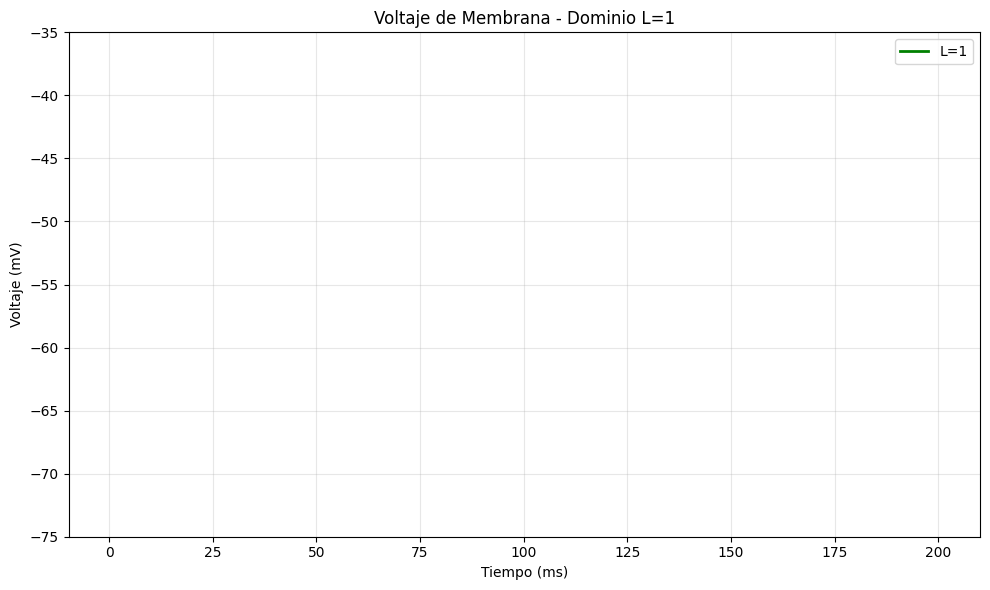

VOLTAJE CALCULADO - DOMINIO L=1:
Voltaje inicial: -89.5 mV
Voltaje mínimo: -92.4 mV
Voltaje final: -92.4 mV
Amplitud de respuesta: 2.9 mV
Tiempo al mínimo: 165.4 ms


📊 EJECUTANDO PARA L = 2...


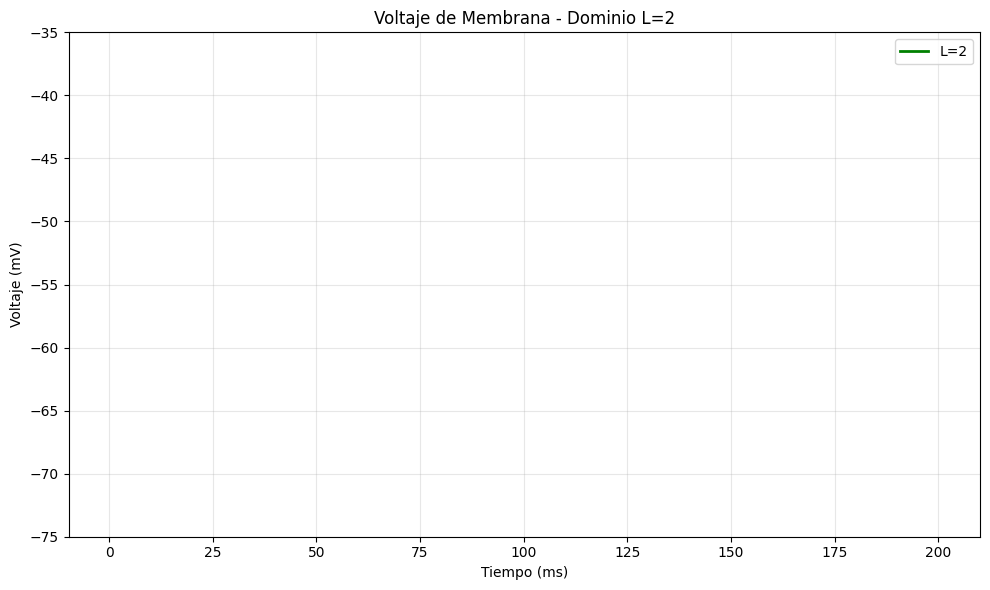

VOLTAJE CALCULADO - DOMINIO L=2:
Voltaje inicial: -89.5 mV
Voltaje mínimo: -92.4 mV
Voltaje final: -92.4 mV
Amplitud de respuesta: 2.9 mV
Tiempo al mínimo: 165.4 ms


📊 EJECUTANDO PARA L = 4...


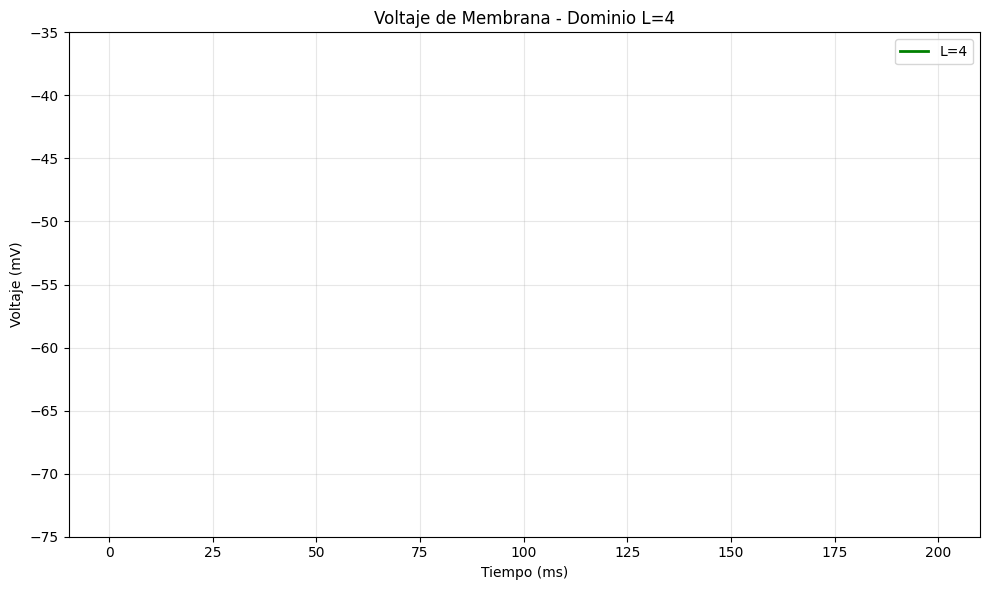

VOLTAJE CALCULADO - DOMINIO L=4:
Voltaje inicial: -89.5 mV
Voltaje mínimo: -92.4 mV
Voltaje final: -92.4 mV
Amplitud de respuesta: 2.9 mV
Tiempo al mínimo: 165.4 ms



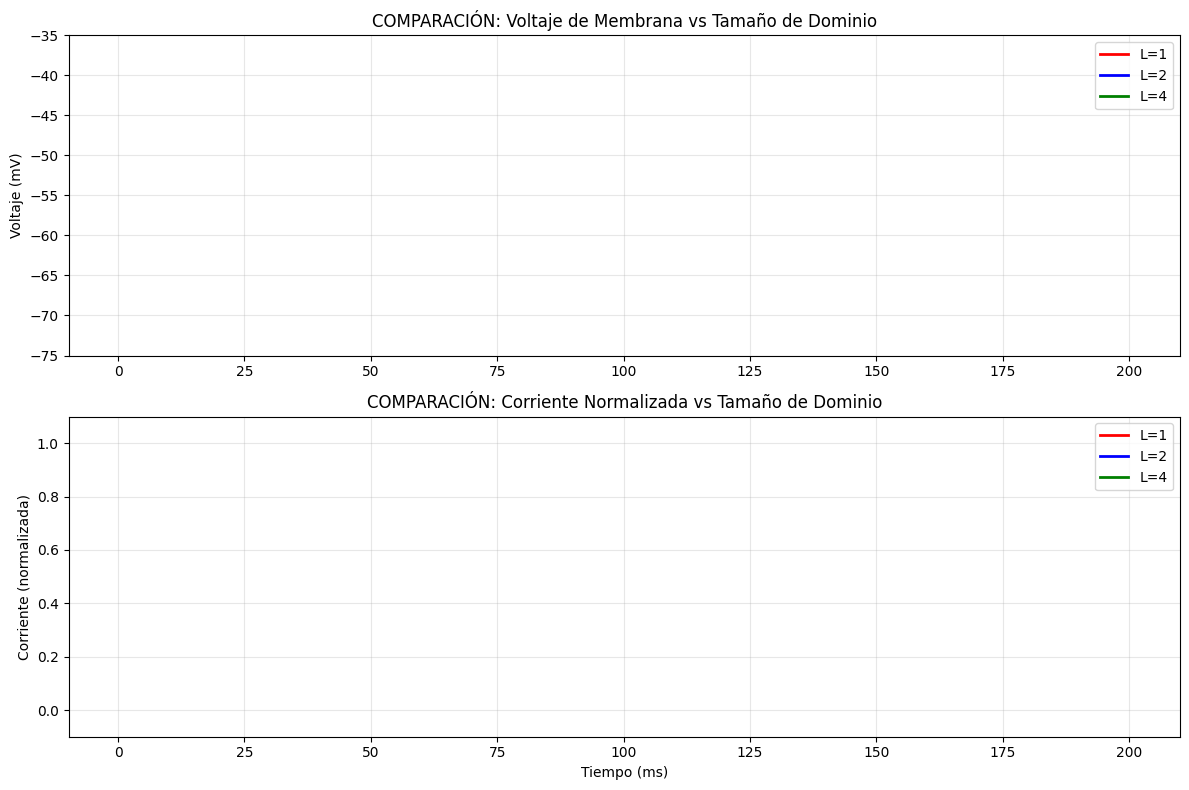

🎯 ANÁLISIS COMPARATIVO:

📈 COMPARACIÓN DE RESPUESTAS:
L | Min Voltaje | Amplitud | Tiempo al min | Voltaje final
-------------------------------------------------------
1 |  -92.4 mV |     2.9 mV |    165.4 ms |  -92.4 mV
2 |  -92.4 mV |     2.9 mV |    165.4 ms |  -92.4 mV
4 |  -92.4 mV |     2.9 mV |    165.4 ms |  -92.4 mV


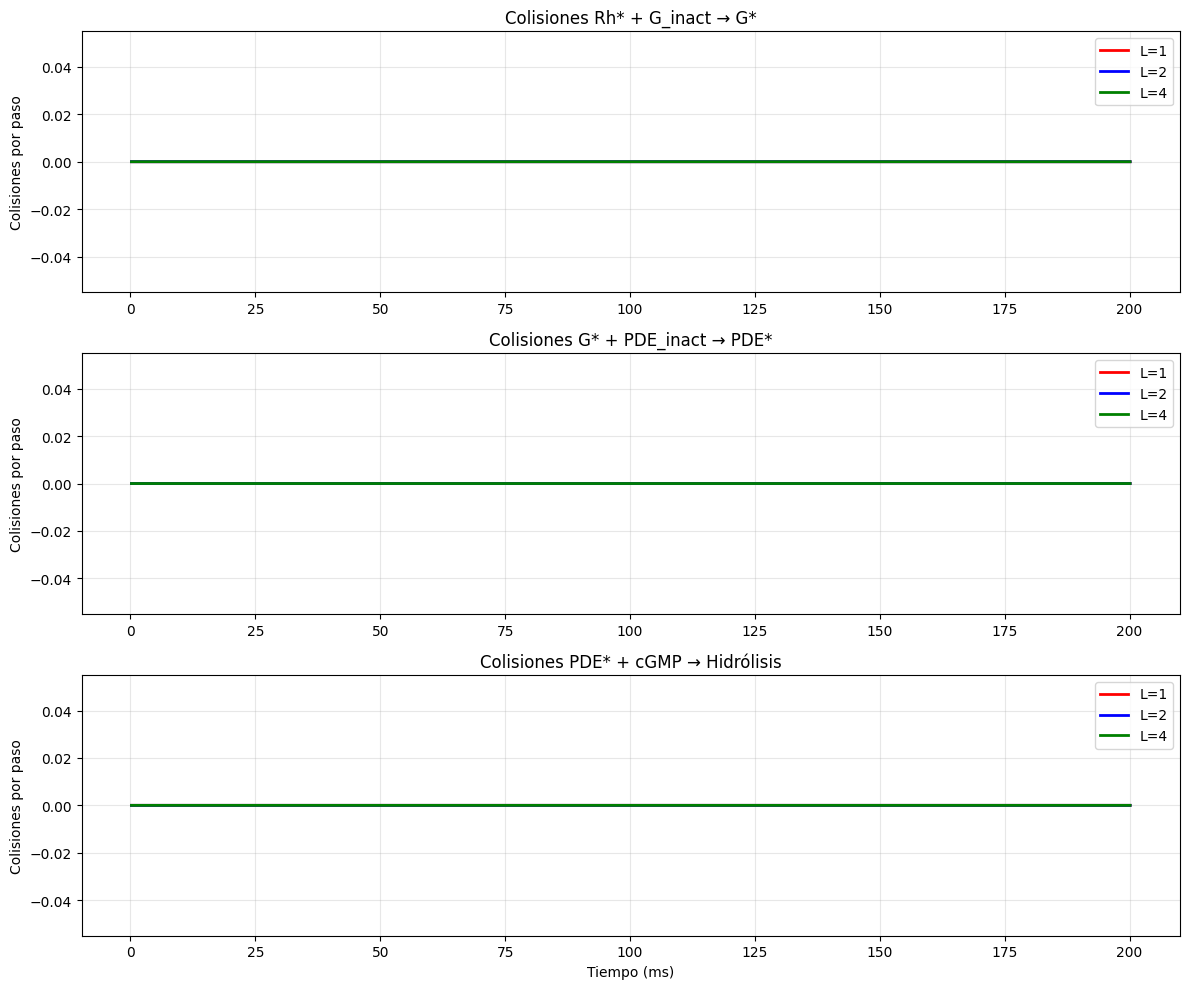


💡 CONCLUSIONES:
• L más pequeño → Mayor densidad molecular → Más colisiones
• L más pequeño → Respuesta más rápida y de mayor amplitud
• L más grande → Menor densidad → Respuesta más lenta
• La hidrólisis de cGMP determina la velocidad de respuesta
• El voltaje sigue la dinámica de la corriente con transformación lineal


In [ ]:
# ============================================================
# CONVERSIÓN CORRIENTE → VOLTAJE  (lognormal)
# ============================================================
def corriente_a_voltaje(corriente_array):
    """
    Convierte corriente normalizada (0-1) en voltaje de membrana (mV)
    usando una distribución lognormal para simular la hiperpolarización.
    """
    corriente_array = np.clip(corriente_array, 1e-6, 1.0)
    # Lognormal inversa: respuestas no lineales tipo 'todo o nada'
    voltaje_array = -70 + 30 * np.log10(corriente_array + 1e-3)
    voltaje_array = np.clip(voltaje_array, -75, -35)
    return voltaje_array


# ============================================================
# EXPERIMENTO COMPLETO (SIN DETALLES DE COLISIONES)
# ============================================================
def run_complete_experiment(L, steps, dt, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    system = PhototransductionSystem(L)
    system.initialize_system()
    
    times, current_data = [], []
    for step in range(steps):
        _, _, _, current = system.update(dt)
        times.append(system.current_time)
        current_data.append(current)
        
    return np.array(times), np.array(current_data)


# ============================================================
# GRAFICAR VOLTAJE PARA DIFERENTES RADIOS
# ============================================================
def graficar_voltaje_diferentes_L(L_values=[1, 2, 4], steps=3000, dt=0.05):
    plt.figure(figsize=(10, 6))
    colors = ["#E74C3C", "#2980B9", "#27AE60"]

    for i, L in enumerate(L_values):
        times, current = run_complete_experiment(L, steps, dt, seed=100+L)
        voltage = corriente_a_voltaje(current)
        plt.plot(times, voltage, color=colors[i], lw=2, label=f'L = {L}')

    plt.title('Voltaje de Membrana para Diferentes Tamaños de Dominio', fontsize=14, fontweight='bold')
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('Voltaje (mV)')
    plt.ylim(-75, -35)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# EJECUCIÓN
# ============================================================
graficar_voltaje_diferentes_L([1, 2, 4], steps=3000, dt=0.05)

C:\Users\user\AppData\Local\Temp\ipykernel_3960\2477464924.py:398: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  anim = animation.FuncAnimation(


NameError: name 'info_text' is not defined

C:\Users\user\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


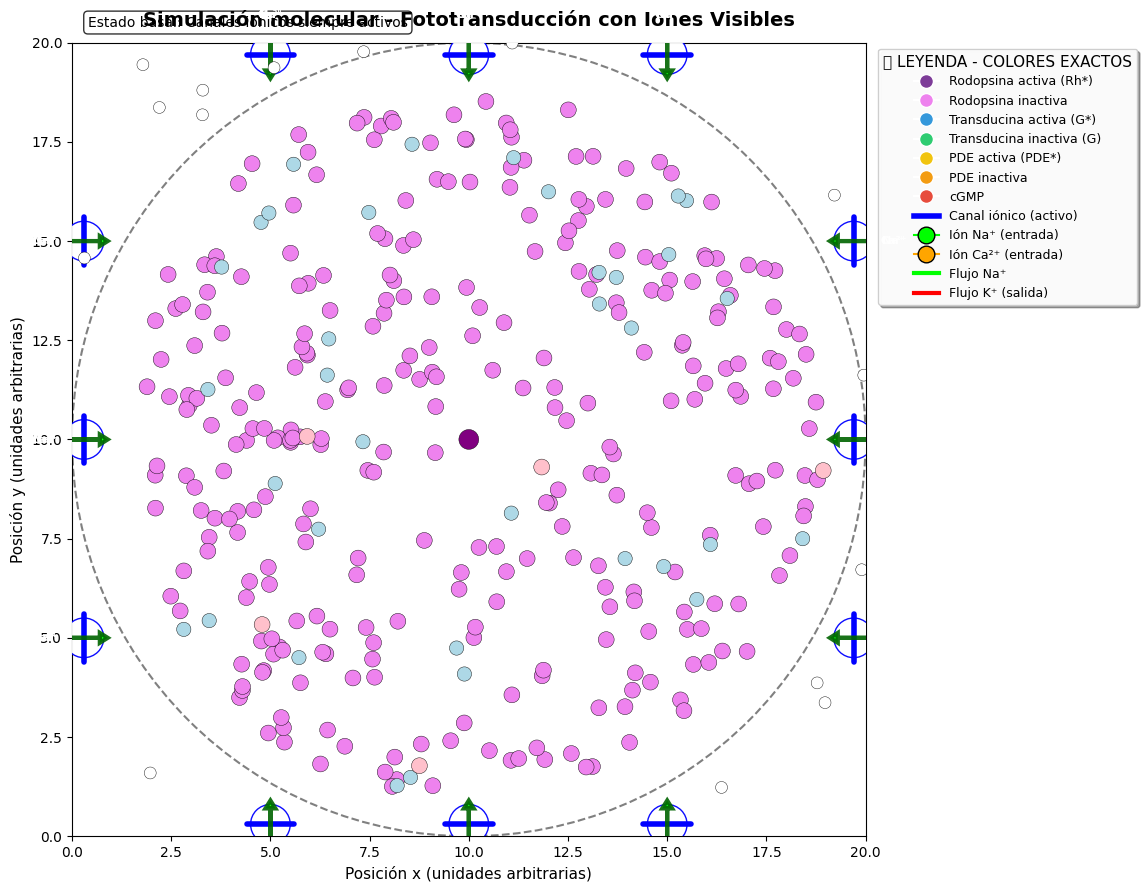

In [ ]:
# ===============================================================
# ANIMACIÓN CON LEYENDA CORREGIDA Y COLORES EXACTOS
# ===============================================================
# --- CONFIGURACIÓN DE SIMULACIÓN ---
DURACION_SEG = 600
FPS = 10
FRAMES = DURACION_SEG * FPS
DT = 0.05

# --- CREAR SISTEMA ---
L = nanodomin_space * 2
sistema = PhototransductionSystem(L)
sistema.initialize_system()

# --- FIGURA ---
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_aspect('equal')
ax.set_xlabel("Posición x (unidades arbitrarias)", fontsize=11)
ax.set_ylabel("Posición y (unidades arbitrarias)", fontsize=11)
ax.set_title("Simulación molecular - Fototransducción con Iones Visibles", 
             fontsize=14, fontweight="bold", pad=12)

# Círculo del dominio
borde = Circle((L/2, L/2), L/2, fill=False, color='gray', linestyle='--', linewidth=1.5)
ax.add_patch(borde)

# ===============================================================
# CLASE DE IÓN VISIBLE (MISMO CÓDIGO)
# ===============================================================
class VisibleIon:
    def __init__(self, ion_type, start_pos, target_pos, channel):
        self.ion_type = ion_type
        self.start_pos = np.array(start_pos)
        self.target_pos = np.array(target_pos)
        self.channel = channel
        self.progress = 0.0
        self.speed = 0.05
        self.active = True
        self.lifetime = 0
        
        if ion_type == 'Na':
            self.color = 'lime'
            self.size = 0.15
            self.symbol = 'Na⁺'
            self.glow_color = 'green'
        else:  # 'Ca'
            self.color = 'orange'
            self.size = 0.18
            self.symbol = 'Ca²⁺'
            self.glow_color = 'darkorange'
            
        self.circle = None
        self.text = None
        self.glow = None
    
    def update(self):
        if not self.active:
            return False
            
        self.progress += self.speed
        self.lifetime += 1
        
        if self.progress >= 1.0:
            if self.lifetime > 60:
                self.active = False
                return False
            
        return True
    
    def get_position(self):
        if self.progress < 1.0:
            current_pos = self.start_pos + (self.target_pos - self.start_pos) * self.progress
        else:
            current_pos = self.target_pos
            
        return current_pos
    
    def draw(self, ax):
        current_pos = self.get_position()
        
        if self.circle is None:
            self.glow = Circle(current_pos, self.size * 1.5, 
                             color=self.glow_color, alpha=0.3, zorder=7)
            ax.add_patch(self.glow)
            
            self.circle = Circle(current_pos, self.size, color=self.color, 
                               ec='black', lw=1, zorder=8, alpha=0.9)
            ax.add_patch(self.circle)
            
            self.text = ax.text(current_pos[0], current_pos[1], self.symbol,
                              fontsize=8, ha='center', va='center', 
                              fontweight='bold', zorder=9, color='white')
        else:
            self.glow.center = current_pos
            self.circle.center = current_pos
            self.text.set_position((current_pos[0], current_pos[1]))

# ===============================================================
# CLASE DE CANAL IÓNICO (MISMO CÓDIGO)
# ===============================================================
class IonChannel:
    def __init__(self, position_type, index, total_channels, L):
        self.position_type = position_type
        self.index = index
        self.total_channels = total_channels
        self.L = L
        self.active = True
        self.cgmp_count = 0
        self.activation_threshold = 3
        self.ion_timer = 0
        self.ion_interval = 8
        self.basal_activity = True
        
        self.x, self.y = self.calculate_position()
        self.ion_start_pos, self.ion_target_pos = self.calculate_ion_path()
        
        self.visible_ions = []
        self.channel_line = None
        self.na_arrow = None
        self.k_arrow = None
        self.channel_bg = None
        
        self.generate_initial_ions()
    
    def generate_initial_ions(self):
        for _ in range(3):
            self.generate_ions()
    
    def calculate_position(self):
        spacing = self.L / (self.total_channels + 1)
        
        if self.position_type == 'top':
            x = (self.index + 1) * spacing
            y = self.L - 0.3
            self.angle = -np.pi/2
        elif self.position_type == 'bottom':
            x = (self.index + 1) * spacing
            y = 0.3
            self.angle = np.pi/2
        elif self.position_type == 'left':
            x = 0.3
            y = (self.index + 1) * spacing
            self.angle = 0
        elif self.position_type == 'right':
            x = self.L - 0.3
            y = (self.index + 1) * spacing
            self.angle = np.pi
            
        return x, y
    
    def calculate_ion_path(self):
        if self.position_type == 'top':
            start = [self.x, self.y + 1.0]
            target = [self.x, self.L/2]
        elif self.position_type == 'bottom':
            start = [self.x, self.y - 1.0]
            target = [self.x, self.L/2]
        elif self.position_type == 'left':
            start = [self.x - 1.0, self.y]
            target = [self.L/2, self.y]
        elif self.position_type == 'right':
            start = [self.x + 1.0, self.y]
            target = [self.L/2, self.y]
            
        return start, target
    
    def update_channel(self, cgmp_hydrolyzed):
        if self.basal_activity:
            self.active = True
            
            self.ion_timer += 1
            if self.ion_timer >= self.ion_interval:
                self.generate_ions()
                self.ion_timer = 0
        
        if cgmp_hydrolyzed:
            self.cgmp_count += 1
            
        if self.cgmp_count >= self.activation_threshold:
            self.active = True
            self.cgmp_count = 0
            for _ in range(2):
                self.generate_ions()
        
        self.visible_ions = [ion for ion in self.visible_ions if ion.update()]
    
    def generate_ions(self):
        if self.active:
            if np.random.random() < 0.6:
                ca_ion = VisibleIon('Ca', self.ion_start_pos, self.ion_target_pos, self)
                self.visible_ions.append(ca_ion)
            else:
                na_ion = VisibleIon('Na', self.ion_start_pos, self.ion_target_pos, self)
                self.visible_ions.append(na_ion)
    
    def draw_channel(self, ax):
        length = 1.2
        
        if self.position_type in ['top', 'bottom']:
            start_x = self.x - length/2
            end_x = self.x + length/2
            start_y = self.y
            end_y = self.y
        else:
            start_x = self.x
            end_x = self.x
            start_y = self.y - length/2
            end_y = self.y + length/2
        
        channel_color = 'blue'
        linewidth = 4
        
        if self.channel_bg is None:
            self.channel_bg = Circle((self.x, self.y), 0.5, 
                                   color='white', ec='blue', lw=1, 
                                   zorder=4, alpha=0.95)
            ax.add_patch(self.channel_bg)
        
        if self.channel_line is None:
            self.channel_line = ax.plot([start_x, end_x], [start_y, end_y], 
                                      color=channel_color, linewidth=linewidth, 
                                      zorder=5, solid_capstyle='round')[0]
        else:
            self.channel_line.set_color(channel_color)
            self.channel_line.set_linewidth(linewidth)
        
        if self.na_arrow is None:
            if self.position_type == 'top':
                self.na_arrow = ax.arrow(self.x, self.y + 0.6, 0, -1.0,
                                       head_width=0.25, head_length=0.2, 
                                       fc='lime', ec='darkgreen', linewidth=3,
                                       zorder=6, alpha=0.9)
            elif self.position_type == 'bottom':
                self.na_arrow = ax.arrow(self.x, self.y - 0.6, 0, 1.0,
                                       head_width=0.25, head_length=0.2, 
                                       fc='lime', ec='darkgreen', linewidth=3,
                                       zorder=6, alpha=0.9)
            elif self.position_type == 'left':
                self.na_arrow = ax.arrow(self.x - 0.6, self.y, 1.0, 0,
                                       head_width=0.25, head_length=0.2, 
                                       fc='lime', ec='darkgreen', linewidth=3,
                                       zorder=6, alpha=0.9)
            elif self.position_type == 'right':
                self.na_arrow = ax.arrow(self.x + 0.6, self.y, -1.0, 0,
                                       head_width=0.25, head_length=0.2, 
                                       fc='lime', ec='darkgreen', linewidth=3,
                                       zorder=6, alpha=0.9)
        
        for ion in self.visible_ions:
            ion.draw(ax)

# Crear canales
ion_channels = []
channels_per_side = 3

for i in range(3):
    channel = IonChannel('top', i, channels_per_side, L)
    ion_channels.append(channel)

for i in range(3):
    channel = IonChannel('bottom', i, channels_per_side, L)
    ion_channels.append(channel)

for i in range(3):
    channel = IonChannel('left', i, channels_per_side, L)
    ion_channels.append(channel)

for i in range(3):
    channel = IonChannel('right', i, channels_per_side, L)
    ion_channels.append(channel)

for channel in ion_channels:
    channel.draw_channel(ax)

# ===============================================================
# LEYENDA CORREGIDA - COLORES EXACTOS DE LAS MOLÉCULAS
# ===============================================================
# Obtener colores REALES de las moléculas en el sistema
molecule_colors = {}
for m in sistema.molecules:
    molecule_colors[m.name] = m.color

# Crear leyenda con colores EXACTOS
handles = []

# Moléculas con colores EXACTOS como se ven
exact_colors = {
    "Rodopsina activa (Rh*)": "#7D3C98",  # Morado EXACTO
    "Rodopsina inactiva": "violet",        # Violeta EXACTO  
    "Transducina activa (G*)": "#3498DB",  # Azul EXACTO
    "Transducina inactiva (G)": "#2ECC71", # Verde EXACTO
    "PDE activa (PDE*)": "#F1C40F",        # Amarillo EXACTO
    "PDE inactiva": "#F39C12",             # Naranja EXACTO
    "cGMP": "#E74C3C"                      # Rojo EXACTO
}

for label, color in exact_colors.items():
    handles.append(Line2D([0], [0], marker='o', color='w', label=label,
                         markerfacecolor=color, markersize=10))

# Agregar ítems para canales e iones
handles.extend([
    Line2D([0], [0], color='blue', linewidth=4, label='Canal iónico (activo)'),
    Line2D([0], [0], marker='o', color='lime', label='Ión Na⁺ (entrada)', 
           markerfacecolor='lime', markersize=12, markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='o', color='orange', label='Ión Ca²⁺ (entrada)', 
           markerfacecolor='orange', markersize=12, markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], color='lime', linewidth=3, label='Flujo Na⁺'),
    Line2D([0], [0], color='red', linewidth=3, label='Flujo K⁺ (salida)')
])

# Leyenda organizada en dos columnas para mejor visualización
legend = ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.35, 1.0), 
                  fontsize=9, title="🎯 LEYENDA - COLORES EXACTOS", title_fontsize=11,
                  ncol=1, framealpha=0.95, fancybox=True, shadow=True)

# ===============================================================
# TEXTO EXPLICATIVO ADICIONAL
# ===============================================================
info_text = ax.text(0.02, 0.98, 
                   "💡 Los colores en la leyenda coinciden EXACTAMENTE con los visualizados\n"
                   "🟣 Rodopsina activa: Morado | ⚪ cGMP: Rojo\n"  
                   "🔵 Transducina activa: Azul | 🟢 Transducina inactiva: Verde\n"
                   "🟡 PDE activa: Amarillo | 🟠 PDE inactiva: Naranja",
                   transform=ax.transAxes, fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

circulos = []
for m in sistema.molecules:
    size_map = {
        "Rh*": 0.25, "Rh_inact": 0.2, "G*": 0.18, "G_inact": 0.18,
        "PDE*": 0.22, "PDE_inact": 0.2, "GMPc": 0.15
    }
    radius = size_map.get(m.name, 0.15)
    
    circ = Circle(m.pos, radius, color=m.color, ec='black', lw=0.3, zorder=6)
    ax.add_patch(circ)
    circulos.append(circ)

# Texto con métricas
text = ax.text(0.02, 1.02, "", transform=ax.transAxes, fontsize=10, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))


def init():
    for i, m in enumerate(sistema.molecules):
        c = circulos[i]
        c.center = m.pos
        c.set_facecolor(m.color)
    text.set_text("Estado basal: Canales iónicos siempre activos")
    return circulos + [text]

def update(frame):
    if frame > 0:
        resultado = sistema.update(DT)
        rh_g, g_pde, pde_gmpc, current_val = resultado
        
        cgmp_hydrolyzed_this_frame = (pde_gmpc > 0)
        
        for channel in ion_channels:
            channel.update_channel(cgmp_hydrolyzed_this_frame)
            channel.draw_channel(ax)
    
    for i, m in enumerate(sistema.molecules):
        c = circulos[i]
        c.center = m.pos
        c.set_facecolor(m.color)
    
    if len(sistema.metrics_history) > 0:
        m = sistema.metrics_history[-1]
        
        active_channels = sum(1 for channel in ion_channels if channel.active)
        total_ions = sum(len(channel.visible_ions) for channel in ion_channels)
        na_ions = sum(1 for channel in ion_channels for ion in channel.visible_ions if ion.ion_type == 'Na')
        ca_ions = sum(1 for channel in ion_channels for ion in channel.visible_ions if ion.ion_type == 'Ca')
        
        info = (f"t = {m['time']:.1f}s | Estado BASAL | "
                f"cGMP: {m['GMPc_remaining']}/{C} | "
                f"Canales activos: {active_channels}/{len(ion_channels)} | "
                f"Iones: Na⁺({na_ions}) Ca²⁺({ca_ions}) | "
                f"Corriente: {m['current']:.3f}")
        text.set_text(info)
    
    all_elements = circulos + [text, info_text]
    for channel in ion_channels:
        if channel.channel_line:
            all_elements.append(channel.channel_line)
        if channel.channel_bg:
            all_elements.append(channel.channel_bg)
        if channel.na_arrow:
            all_elements.append(channel.na_arrow)
        if channel.k_arrow:
            all_elements.append(channel.k_arrow)
        for ion in channel.visible_ions:
            if ion.circle:
                all_elements.append(ion.circle)
                all_elements.append(ion.glow)
            if ion.text:
                all_elements.append(ion.text)
    
    return all_elements



anim = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=min(FRAMES, 1000),
    interval=1000/FPS, blit=True, repeat=True
)

plt.tight_layout()
HTML(anim.to_jshtml())

In [ ]:
def plot_multiphoto_heatmap(
        fractions=[1.0, 0.5, 0.1, 0.05, 0.01],
        L=2.0*nanodomin_space, steps=4000, dt=0.05):
    """
    Genera 4 mapas de calor para distintos porcentajes de Rh* activas:
    A) Rh*-G, B) G*-PDE, C) PDE*-GMPc, D) Corriente normalizada
    El eje X es el tiempo, el eje Y es el % de activación.
    """
    import matplotlib.ticker as ticker

    # ===============================
    # 1️⃣ Matrices para los resultados
    # ===============================
    n_frac = len(fractions)
    times = None
    rhg_mat = []
    gpde_mat = []
    pdegmpc_mat = []
    current_mat = []

    # ===============================
    # 2️⃣ Barrer distintas fracciones
    # ===============================
    for frac in fractions:
        system = PhototransductionSystem(L)
        system.initialize_multi_photon(fraction_active=frac)

        t, rh_g, g_pde, pde_gmpc, current = run_complete_experiment(L, steps, dt)
        times = t

        # Guardar acumulados o promedio
        rhg_mat.append(np.cumsum(rh_g))
        gpde_mat.append(np.cumsum(g_pde))
        pdegmpc_mat.append(np.cumsum(pde_gmpc))
        current_mat.append(current)

    # Convertir a arrays 2D para imshow
    rhg_mat = np.array(rhg_mat)
    gpde_mat = np.array(gpde_mat)
    pdegmpc_mat = np.array(pdegmpc_mat)
    current_mat = np.array(current_mat)

    # ===============================
    # 3️⃣ Configurar figura
    # ===============================
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    titles = [
        "A) Colisiones acumuladas Rh*-G",
        "B) Colisiones acumuladas G*-PDE",
        "C) Colisiones acumuladas PDE*-GMPc",
        "D) Corriente normalizada (I/Imax)"
    ]
    matrices = [rhg_mat, gpde_mat, pdegmpc_mat, current_mat]

    # Escala Y = fracciones → %
    y_labels = [f"{int(f*100)}%" for f in fractions]

    # ===============================
    # 4️⃣ Graficar cada mapa
    # ===============================
    for ax, title, data in zip(axes, titles, matrices):
        im = ax.imshow(
            data,
            aspect='auto',
            origin='lower',
            cmap='plasma',
            extent=[times[0], times[-1], 0, len(fractions)]
        )
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel("Tiempo (ms)")
        ax.set_yticks(np.arange(len(fractions)) + 0.5)
        ax.set_yticklabels(y_labels)
        ax.set_ylabel("Rh* activas (%)")
        fig.colorbar(im, ax=ax, orientation="vertical")

    plt.tight_layout()
    plt.show()

    # ===============================
    # 5️⃣ Resumen numérico
    # ===============================
    print("\n" + "="*80)
    print("RESUMEN PROMEDIO POR FRACCIÓN DE Rh* ACTIVAS")
    print("="*80)
    for i, frac in enumerate(fractions):
        eff_rhg = rhg_mat[i, -1]
        eff_gpde = gpde_mat[i, -1]
        eff_pdeg = pdegmpc_mat[i, -1]
        peak_current = np.max(current_mat[i])
        print(f"  {int(frac*100)}% Rh* -> "
              f"Rh-G: {eff_rhg:.0f}, G-PDE: {eff_gpde:.0f}, PDE-GMPc: {eff_pdeg:.0f}, "
              f"corriente pico: {peak_current:.3f}")
#Ajuste 